In [14]:
import numpy as np
import pandas as pd
import pyodbc
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import math
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#from bokeh.io import output_notebook, show, curdoc, output_file,push_notebook
#from bokeh.layouts import widgetbox, row
#from bokeh.plotting import figure
#from bokeh.models import HoverTool, ColumnDataSource, Slider, CDSView, GroupFilter,BooleanFilter
#from bokeh.transform import factor_cmap
#from bokeh.palettes import all_palettes
#from bokeh.models.widgets import TextInput

conn=pyodbc.connect('Driver={SQL Server};'
                      'Server=balt-sql-fc;'
                      'Database=CitiStat;'
                      'Trusted_Connection=yes;')

In [2]:
quads = ['NE','NW','SE','SW']
data_quad=pd.DataFrame({
    'quad'       : quads,
    'crew_size'  : [3,3,3,3],
    'rate' : [10,10,10,10],
    'worksite_diff' : [1,0.8,1.2,0.75],
    #'worksite_diff' : [1,1,1,1],
    'absence_rate': [0.9,0.83,0.9,0.78]
    #'absence_rate': [1,1,1,1]
})

In [45]:
init_back =  pd.read_sql('''select quad, 
count([Record ID]) as backlog
from (select [Record ID], 
	case when [Status] like 'CLOSE%' then 'Closed'
			when [Status] like 'CANCEL%' then 'Cancelled'
			WHEN [Date Finish] is null THEN 'Open'
			end as complete_status,
			[Clean Size],
	case when [Solid Waste Quadrant] = 'NORTHEAST' THEN 'NE'
		WHEN [Solid Waste Quadrant] = 'NORTHWEST' THEN 'NW'
		WHEN [Solid Waste Quadrant] = 'SOUTHEAST' THEN 'SE'
		WHEN [Solid Waste Quadrant] = 'SOUTHWEST' THEN 'SW'
		END AS	quad
from CitiStat.dbo.CHIP_WorkOrders
where 1=1
and [Work Order Type]='Cleaning'
and [Date Finish] is null
and [Solid Waste Quadrant] in ('NORTHEAST','SOUTHEAST','SOUTHWEST','NORTHWEST')
) foo
where 1=1
group by quad
''',conn)
init_back.to_csv('initial_backlog.csv')

In [4]:
data_quad = data_quad.merge(init_back,how='left', on ='quad' )

In [44]:
wo_creation_hist = pd.read_sql('''
select month(date_create) month, quad, avg(wo_count) avg_wo, stdev(wo_count) sd_wo
from
(select [date_create], quad, count([Record ID]) wo_count
from (
select  [Record ID], 
		cast([Date Create] as DATE) as date_create,
		[Clean Size],
	case when [Solid Waste Quadrant] = 'NORTHEAST' THEN 'NE'
		WHEN [Solid Waste Quadrant] = 'NORTHWEST' THEN 'NW'
		WHEN [Solid Waste Quadrant] = 'SOUTHEAST' THEN 'SE'
		WHEN [Solid Waste Quadrant] = 'SOUTHWEST' THEN 'SW'
		END AS	quad
from CitiStat.dbo.CHIP_WorkOrders
where 1=1
and [Work Order Type]='Cleaning'
and [Date Create] between '2019-01-01' and '2020-01-01'
and [Solid Waste Quadrant] in ('NORTHEAST','SOUTHEAST','SOUTHWEST','NORTHWEST')
) foo
where 1=1
group by date_create, quad
) foo
group by month(date_create),quad
order by month, quad''',conn)
wo_creation_hist.to_csv('historical_creation.csv')

In [6]:
def quad_calc(data,backlog,quadrant,day):
    quad = data[data['quad']==quadrant].reset_index()
    back = backlog.loc[(backlog['quad']==quadrant)&(backlog['system']=='quadrant')&(backlog['day']==day),'backlog'].values[0]
    new_backlog = back-quad.loc[0,'crew_size']*quad.loc[0,'rate']*quad.loc[0,'worksite_diff']
    if new_backlog > 0:
        return new_backlog
    else:
        return 0

def total_calc(data,backlog,order_array,day):
    quad_work = order_array[day-1]
    new_backlog = backlog.loc[(backlog['system']=='total')&(backlog['day']==day),['quad','system','day','backlog']]
    calc = new_backlog.loc[new_backlog['quad']==quad_work,'backlog'].values-np.dot(data['crew_size'],data['rate']) * data.loc[data['quad']==quad_work,'worksite_diff']
    if calc.values[0] > 0:
        new_backlog.loc[new_backlog['quad']==quad_work,'backlog'] = calc.values[0]
        
    else:
        new_backlog.loc[new_backlog['quad']==quad_work,'backlog'] = 0
    new_backlog.loc[:,'day'] = new_backlog.loc[:,'day']+1 
    return new_backlog

def all_days_count(data_q,data_b,tot_order):
    for j in data_q['quad']:
        for i in [1,2,3,4]:
            data_b.loc[(data_b['quad']==j)&(data_b['day']==i+1)&(data_b['system']=='quadrant'),'backlog'] = quad_calc(data_q,data_b,j,i)
            data_b= data_b.merge(total_calc(data_q,data_b,tot_order,i), on=['quad','day','system'],how='left')
            data_b['backlog'] = np.min(data_b[['backlog_x', 'backlog_y']], axis=1)
            data_b = data_b.drop(labels=['backlog_x', 'backlog_y'], axis=1)
    return data_b

def absence(absence_rate,no_crews):
    a = np.random.binomial(1, absence_rate, no_crews)
    return a

def wo_creation(date,quad):
    month = date.month
    avg_work = wo_creation_hist.loc[(wo_creation_hist['quad']==quad)&(wo_creation_hist['month']==month),'avg_wo'].values[0]
    sd_work = wo_creation_hist.loc[(wo_creation_hist['quad']==quad)&(wo_creation_hist['month']==month),'sd_wo'].values[0]
    wo = math.ceil(np.random.normal(avg_work,sd_work))
    return wo

In [7]:
dates =  pd.to_datetime(datetime.today().strftime('%Y-%m-%d')) + pd.to_timedelta(np.arange(731), 'D')

### Quad System Calculation

In [8]:
quad_backlog = pd.DataFrame(dates)
quad_backlog.columns = ['Date']
add_wo = 1
for j in quads:
    temp = data_quad[data_quad['quad']==j].reset_index()
    backlog = temp['backlog'].values[0]
    quad_sys_backlog = [backlog]
    for i in range(1,len(dates)):
        if add_wo == 1:
            work_created = wo_creation(quad_backlog.loc[i,'Date'],j)
        elif add_wo == 0:
            work_created = 0
        crews4day= absence(temp['absence_rate'],temp['crew_size'])
        work_completed = sum(crews4day*temp['rate'].values[0])*temp['worksite_diff'].values[0]
        backlog = backlog-work_completed+work_created
        if backlog < 0:
            backlog=0
        quad_sys_backlog.append(backlog)
    quad_backlog[j] = quad_sys_backlog
quad_backlog['Total'] = quad_backlog['NE']+quad_backlog['SE']+quad_backlog['SW']+quad_backlog['NW']


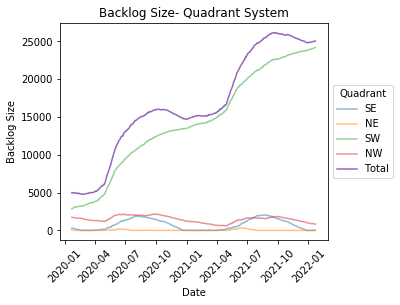

In [43]:
fig = plt.figure()
ax = plt.subplot(111)

for i in ['SE','NE','SW','NW','Total']:
    if i == 'Total':
        ax.plot(quad_backlog['Date'],quad_backlog[i])
    else:
        ax.plot(quad_backlog['Date'],quad_backlog[i],alpha = .5)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.title("Backlog Size- Quadrant System")
plt.ylabel("Backlog Size")
plt.xlabel("Date")
plt.xticks(rotation=45) 

# Put a legend to the right of the current axis
ax.legend(['SE','NE','SW','NW','Total'],title= 'Quadrant',loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Total System Calculation

In [10]:
total_backlog = pd.DataFrame(dates)
total_backlog.columns = ['Date']
total_backlog['NE'], total_backlog['NW'],total_backlog['SE'],total_backlog['SW'] = np.nan,np.nan,np.nan,np.nan
total_backlog.loc[0,'NE'] = data_quad.loc[data_quad['quad']=='NE','backlog'].values
total_backlog.loc[0,'NW'] = data_quad.loc[data_quad['quad']=='NW','backlog'].values
total_backlog.loc[0,'SE'] = data_quad.loc[data_quad['quad']=='SE','backlog'].values
total_backlog.loc[0,'SW'] = data_quad.loc[data_quad['quad']=='SW','backlog'].values
tot_order =['SW','NW','NE','SW','SE']
work_days = len(tot_order)
add_wo = 1
for i in range(1,len(dates)):
    workbycrew = 0
    for j in quads:
        workbycrew= workbycrew + sum(absence(data_quad.loc[data_quad['quad']==j,'absence_rate'].values,data_quad.loc[data_quad['quad']==j,'crew_size'].values) * data_quad.loc[data_quad['quad']==j,'rate'].values)
        if add_wo == 1:
            work_created = wo_creation(total_backlog.loc[i,'Date'],j)
        elif add_wo == 0:
            work_created = 0
        total_backlog.loc[i,j] = total_backlog.loc[i-1,j]+work_created
    work_completed = workbycrew*data_quad.loc[data_quad['quad']==tot_order[i%work_days],'worksite_diff'].values
    total_backlog.loc[i,tot_order[i%work_days]] = total_backlog.loc[i-1,tot_order[i%work_days]]-work_completed
    if total_backlog.loc[i,tot_order[i%work_days]] < 0:
        total_backlog.loc[i,tot_order[i%work_days]] = 0
total_backlog['Total'] = total_backlog['NE']+total_backlog['SE']+total_backlog['SW']+total_backlog['NW']

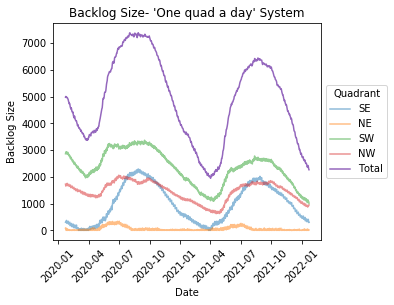

In [42]:
fig = plt.figure()
ax = plt.subplot(111)

for i in ['SE','NE','SW','NW','Total']:
    if i == 'Total':
        ax.plot(total_backlog['Date'],total_backlog[i])
    else:
        ax.plot(total_backlog['Date'],total_backlog[i],alpha = .5)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.title("Backlog Size- 'One quad a day' System")
plt.ylabel("Backlog Size")
plt.xlabel("Date")
plt.xticks(rotation=45) 

# Put a legend to the right of the current axis
ax.legend(['SE','NE','SW','NW','Total'],title= 'Quadrant',loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Put people where the work is

In [12]:
dist_backlog = pd.DataFrame(dates)
dist_backlog.columns = ['Date']
dist_backlog['NE'], dist_backlog['NW'],dist_backlog['SE'],dist_backlog['SW'], dist_backlog['Total']= np.nan,np.nan,np.nan,np.nan,np.nan
dist_backlog.loc[0,'NE'] = data_quad.loc[data_quad['quad']=='NE','backlog'].values
dist_backlog.loc[0,'NW'] = data_quad.loc[data_quad['quad']=='NW','backlog'].values
dist_backlog.loc[0,'SE'] = data_quad.loc[data_quad['quad']=='SE','backlog'].values
dist_backlog.loc[0,'SW'] = data_quad.loc[data_quad['quad']=='SW','backlog'].values
dist_backlog['Total'] = dist_backlog['NE']+dist_backlog['SE']+dist_backlog['SW']+dist_backlog['NW']
add_wo = 1
for i in range(1,len(dist_backlog)):
    crews_av = 0 
    for j in quads:
        crews_av= crews_av + sum(absence(data_quad.loc[data_quad['quad']==j,'absence_rate'].values,data_quad.loc[data_quad['quad']==j,'crew_size'].values))
    #print('Crews Available: ' + str(crews_av))
    day_dist = round((dist_backlog.iloc[i-1,1:5]/dist_backlog.loc[i-1,'Total'] * crews_av).astype(np.double))
    #print('Crew Distribution: ' + str(day_dist))
    for j in quads:
        work_completed = day_dist[j]*data_quad.loc[data_quad['quad']==j,'rate'].values*data_quad.loc[data_quad['quad']==j,'worksite_diff'].values
        #print('Completed Work in ' +str(j)+' : ' + str(work_completed))
        if add_wo == 1:
            work_created = wo_creation(dist_backlog.loc[i,'Date'],j)
        elif add_wo == 0:
            work_created = 0
        #print('Work Created in ' + str(j) +': '+ str(work_created))
        dist_backlog.loc[i,j] = dist_backlog.loc[i-1,j]+work_created-work_completed
        if dist_backlog.loc[i,j] < 0:
            dist_backlog.loc[i,j] = 0
    dist_backlog.loc[i,'Total'] = dist_backlog.loc[i,'NE']+dist_backlog.loc[i,'SE']+dist_backlog.loc[i,'SW']+dist_backlog.loc[i,'NW']
    #print(dist_backlog.loc[i,:])
#dist_backlog.head()

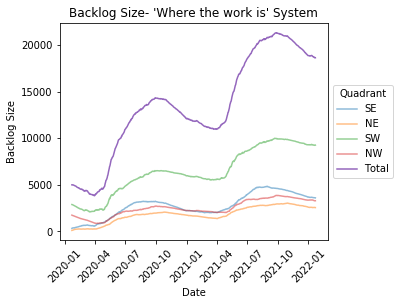

In [40]:
fig = plt.figure()
ax = plt.subplot(111)

for i in ['SE','NE','SW','NW','Total']:
    if i == 'Total':
        ax.plot(dist_backlog['Date'],dist_backlog[i])
    else:
        ax.plot(dist_backlog['Date'],dist_backlog[i],alpha = .5)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.title("Backlog Size- 'Where the work is' System")
plt.ylabel("Backlog Size")
plt.xlabel("Date")
plt.xticks(rotation=45) 

# Put a legend to the right of the current axis
ax.legend(['SE','NE','SW','NW','Total'],title= 'Quadrant',loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()